In [ ]:
!apt install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cuda is already the newest version (11.5.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import numpy as np

plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from pytorch_forecasting.metrics import MAE, RMSE, MAPE

warnings.filterwarnings('ignore')


def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 11 23:34:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-1-01 00:00:00']

In [ ]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

In [ ]:
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
1,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
2,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
3,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
4,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.35,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,NaN,NaN,NaN,5.33,3.93,3.85,6.58,6.73,NaN,1.87,10.78,10.60,21.62,21.37,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,16.75,16.45,10.78,10.95,6.43,7.02,16.57,16.53,4.12,4.25,3.57,3.52,NaN,NaN,10.83,...,17.18,17.52,12.40,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.95,13.97,15.32

In [ ]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.90,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55868,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55869,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55870,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72


In [ ]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [ ]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,travel_time_9,travel_time_10,travel_time_11,travel_time_12,travel_time_13,travel_time_14,travel_time_15,travel_time_16,travel_time_17,travel_time_18,travel_time_19,travel_time_20,travel_time_21,travel_time_22,travel_time_23,travel_time_24,travel_time_25,travel_time_26,travel_time_27,travel_time_28,travel_time_29,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39,travel_time_40
0,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
5,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
6,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
7,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
8,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80
9,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80


In [ ]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
print(total_data)

       travel_time_0  travel_time_1  ...  travel_time_39  travel_time_40
0              10.90          11.55  ...           15.75           15.78
1              10.90          11.55  ...           15.75           15.78
2              10.90          11.55  ...           15.75           15.78
3              10.90          11.55  ...           15.75           15.78
4              10.90          11.55  ...           15.75           15.78
...              ...            ...  ...             ...             ...
55867          10.88          11.60  ...           15.70           15.72
55868          10.88          11.60  ...           15.70           15.72
55869          10.88          11.60  ...           15.70           15.72
55870          10.88          11.60  ...           15.70           15.72
55871          10.88          11.60  ...           15.70           15.72

[55872 rows x 41 columns]


In [ ]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(total_data)
# train = scaler.transform(train_data)
total = scaler.transform(total_data)

sc = MinMaxScaler()
total_data = sc.fit_transform(total_data)

## 15 minutes horizon
trn_x_15min, trn_y_15min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 2)  #every 2 hours.
vld_x_15min, vld_y_15min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 2)  #every 2 hours.
tst_x_15min, tst_y_15min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 2)  #every 2 hours.

trn_x_15min = trn_x_15min.reshape(-1,time_steps, num_corridor)
vld_x_15min = vld_x_15min.reshape(-1,time_steps, num_corridor)
tst_x_15min = tst_x_15min.reshape(-1,time_steps, num_corridor)


## 30 minutes horizon
trn_x_30min, trn_y_30min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 5)  #every 2 hours.
vld_x_30min, vld_y_30min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 5)  #every 2 hours.
tst_x_30min, tst_y_30min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 5)  #every 2 hours.

trn_x_30min = trn_x_30min.reshape(-1,time_steps, num_corridor)
vld_x_30min = vld_x_30min.reshape(-1,time_steps, num_corridor)
tst_x_30min = tst_x_30min.reshape(-1,time_steps, num_corridor)


## 45 minutes horizon
trn_x_45min, trn_y_45min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 8)  #every 2 hours.
vld_x_45min, vld_y_45min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 8)  #every 2 hours.
tst_x_45min, tst_y_45min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 8)  #every 2 hours.

trn_x_45min = trn_x_45min.reshape(-1,time_steps, num_corridor)
vld_x_45min = vld_x_45min.reshape(-1,time_steps, num_corridor)
tst_x_45min = tst_x_45min.reshape(-1,time_steps, num_corridor)


In [ ]:
# conver the data to tensors and pass to the Dataloader 
# to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
# A custom attention layer
class SelfAttention(nn.Module):
    def __init__(self, attention_size, att_hops, non_linearity="tanh"):
        super(SelfAttention, self).__init__()

        self.ut_dense =  nn.Sequential(
                nn.Linear(hidden_size, attention_size),
                nn.Tanh()
         )
        
        self.et_dense = nn.Linear(attention_size, att_hops)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):

        ##################################################################
        # STEP 1 - perform dot product
        # of the attention vector and each hidden state
        ##################################################################

        # inputs is a 3D Tensor: batch, len, hidden_size
        # scores is a 2D Tensor: batch, len
        ut = self.ut_dense(inputs)

        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        att_scores = self.softmax(torch.permute(et, (0, 2, 1)))

        # # re-normalize the masked scores
        # _sums = scores.sum(-1, keepdim=True)  # sums per row
        # att_scores = scores.div(_sums)  # divide by row sum

        ##################################################################
        # Step 2 - Weighted sum of hidden states, by the attention scores
        ##################################################################
        
        # print("att_scores.shape: ", att_scores.shape, "inputs.shape", inputs.shape)

        # multiply each hidden state with the attention weights
        output = torch.bmm(att_scores, inputs)

        return output, att_scores

In [ ]:
# A custom attention layer
# class SelfAttention(nn.HybridBlock):
#     def __init__(self, att_unit, att_hops, **kwargs):
#         super(SelfAttention, self).__init__(**kwargs)
#         with self.name_scope():
#             self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)

#         # # output layer
#         # self.output_layer =  nn.Sequential(
#         #     nn.Linear(hidden_size, nfc),
#         #     nn.ReLU(),
#         #     nn.Dropout(drop_prob),
#         #     nn.Linear(nfc, nfc),
#         #     nn.ReLU(), 
#         #     nn.Dropout(drop_prob),
#         #     nn.Linear(nfc, num_corridor),
#         # )

#         self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

#     def hybrid_forward(self, F, x):
#         # x shape: [batch_size, seq_len, LSTM_nhidden]
#         # ut shape: [batch_size, seq_len, att_unit]
#         ut = self.ut_dense(x)
#         # et shape: [batch_size, seq_len, att_hops]
#         et = self.et_dense(ut)

#         # att shape: [batch_size,  att_hops, seq_len]
#         att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)  
#         # output shape [batch_size, att_hops, LSTM_nhidden]
#         output = F.batch_dot(att, x)

#         return output, att

In [ ]:
"""
Attention mechanism in Hierarchical LSTM
"""

class HierLstm(nn.Module):

    def __init__(self, num_corridor, hidden_size, num_layers, natt_unit, natt_hops, nfc, drop_prob):
        super(HierLstm, self).__init__()

        self.input_size = num_corridor
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # default maximum upgrade length
        self.up_len = 80

        # bottom layer of LSTM
        self.bot_lstm = nn.LSTM(num_corridor, hidden_size, num_layers, batch_first=True)             

        # top layer of LSTM
        self.top_lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)           

        # output layer
        self.output_layer =  nn.Sequential(
            nn.Linear(hidden_size, nfc),
            nn.ReLU(),
            nn.Linear(nfc, num_corridor)
        )

    def forward(self, x):

        bot_lstm_out, _ = self.bot_lstm(x)  # output, (hidden, cell) = lstm(input_data, begin_state)
        # print("bot_lstm_out shape", bot_lstm_out.shape)
        # print("lstm_output shape", lstm_output.shape)  #(batch, sequence, hidden)

        output = None   # output of VLAttHierLstm

        seq_len = x.shape[1]
        batch_Size = x.shape[0]
        # print("seq_len: ", seq_len, "  ", "batch_Size: ", batch_Size)

        # set upgrade length
        up_len = min(self.up_len, math.floor(math.sqrt(seq_len)))
        # evenly spaced index
        idx = np.linspace(up_len - 1, math.pow(up_len, 2) - 1, num = up_len)
        # print(idx)

        # input for top lstm
        up_x = torch.cat([bot_lstm_out[:, int(i), :] for i in idx])
        # append the last output of bottom lstm
        if idx[-1] != seq_len - 1:
            up_x = torch.cat((up_x, bot_lstm_out[:, -1, :]))

        # print("up_x.shape: ", up_x.view(batch_Size, -1, self.hidden_size).shape)

        # top_lstm_out is cancatenated hidden states 
        top_lstm_out, (h_out, _) = self.top_lstm(up_x.view(batch_Size, -1, self.hidden_size))
        # h_out.shape (num_layers, batch, hidden_size)
        # top_lstm_out = top_lstm_out.view(-1, self.hidden_size)
        # print(h_out.shape)
        h_out = torch.transpose(h_out, 0, 1)
        output = self.output_layer(h_out.view(batch_Size, self.hidden_size))

        return output

num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstm(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc, drop_prob)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 15 minutes Horizon

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_15min)))
trainY = Variable(torch.Tensor(np.array(trn_y_15min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_15min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_15min)))

testX = Variable(torch.Tensor(np.array(tst_x_15min)))
testY = Variable(torch.Tensor(np.array(tst_y_15min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTM_15min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            y_pred = sc.inverse_transform(y_pred)
            targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.00849343 val_loss: 0.00839859 
epoch: 20 | trn_loss: 0.00843549 val_loss: 0.00838560 
epoch: 30 | trn_loss: 0.00825020 val_loss: 0.00854870 
epoch: 40 | trn_loss: 0.00789570 val_loss: 0.00924049 
epoch: 50 | trn_loss: 0.00740137 val_loss: 0.00936427 
epoch: 60 | trn_loss: 0.00673043 val_loss: 0.00960460 
epoch: 70 | trn_loss: 0.00606652 val_loss: 0.00954433 
epoch: 80 | trn_loss: 0.00528861 val_loss: 0.01004743 
epoch: 90 | trn_loss: 0.00453150 val_loss: 0.01094719 
epoch: 100 | trn_loss: 0.00375592 val_loss: 0.01099911 
epoch: 110 | trn_loss: 0.00342183 val_loss: 0.01145933 
epoch: 120 | trn_loss: 0.00308978 val_loss: 0.01134651 
epoch: 130 | trn_loss: 0.00280305 val_loss: 0.01147332 
epoch: 140 | trn_loss: 0.00248366 val_loss: 0.01140854 
epoch: 150 | trn_loss: 0.00233212 val_loss: 0.01117030 
epoch: 160 | trn_loss: 0.00215173 val_loss: 0.01120082 
epoch: 170 | trn_loss: 0.00208088 val_loss: 0.01074197 
epoch: 180 | trn_loss: 0.00197967 val_loss: 0.01095573 
e

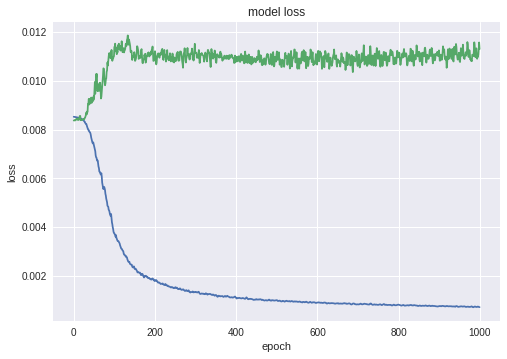

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 30 Minutes Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.2         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstm(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc, drop_prob)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_30min)))
trainY = Variable(torch.Tensor(np.array(trn_y_30min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_30min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_30min)))

testX = Variable(torch.Tensor(np.array(tst_x_30min)))
testY = Variable(torch.Tensor(np.array(tst_y_30min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTM_30min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            y_pred = sc.inverse_transform(y_pred)
            targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.00862856 val_loss: 0.00845459 
epoch: 20 | trn_loss: 0.00855818 val_loss: 0.00846362 
epoch: 30 | trn_loss: 0.00839334 val_loss: 0.00853016 
epoch: 40 | trn_loss: 0.00799325 val_loss: 0.00867784 
epoch: 50 | trn_loss: 0.00741692 val_loss: 0.00913499 
epoch: 60 | trn_loss: 0.00680978 val_loss: 0.00956004 
epoch: 70 | trn_loss: 0.00613002 val_loss: 0.01003824 
epoch: 80 | trn_loss: 0.00540286 val_loss: 0.01033455 
epoch: 90 | trn_loss: 0.00459030 val_loss: 0.01137727 
epoch: 100 | trn_loss: 0.00396086 val_loss: 0.01101422 
epoch: 110 | trn_loss: 0.00339835 val_loss: 0.01169803 
epoch: 120 | trn_loss: 0.00305044 val_loss: 0.01137507 
epoch: 130 | trn_loss: 0.00283102 val_loss: 0.01171609 
epoch: 140 | trn_loss: 0.00263878 val_loss: 0.01150638 
epoch: 150 | trn_loss: 0.00242412 val_loss: 0.01168532 
epoch: 160 | trn_loss: 0.00224932 val_loss: 0.01107186 
epoch: 170 | trn_loss: 0.00208048 val_loss: 0.01153463 
epoch: 180 | trn_loss: 0.00197684 val_loss: 0.01160835 
e

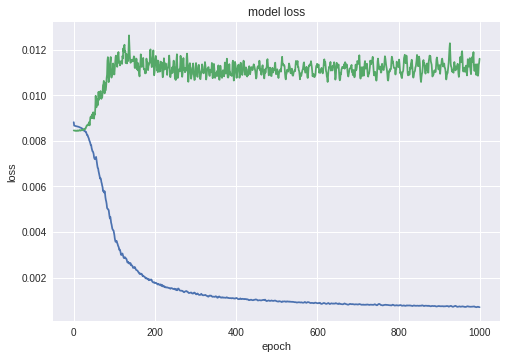

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 45 minute Horizon

In [ ]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 1          # lstm layers
attention_size = 300     # the hidden_units of attention layer
natt_hops = 2
nfc = 512               # fully connected layer
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HierLstm(num_corridor, hidden_size, num_layers, attention_size, natt_hops, nfc, drop_prob)
model = model.to(device)

learning_rate =  0.001

num_epochs = 1000

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_45min)))
trainY = Variable(torch.Tensor(np.array(trn_y_45min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_45min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_45min)))

testX = Variable(torch.Tensor(np.array(tst_x_45min)))
testY = Variable(torch.Tensor(np.array(tst_y_45min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/hiLSTM_45min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            y_pred = sc.inverse_transform(y_pred)
            targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(targets, y_pred)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("Best Model mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 0.00856973 val_loss: 0.00878896 
epoch: 20 | trn_loss: 0.00852245 val_loss: 0.00874892 
epoch: 30 | trn_loss: 0.00843116 val_loss: 0.00881884 
epoch: 40 | trn_loss: 0.00811844 val_loss: 0.00881189 
epoch: 50 | trn_loss: 0.00754713 val_loss: 0.00915119 
epoch: 60 | trn_loss: 0.00638659 val_loss: 0.00993274 
epoch: 70 | trn_loss: 0.00558245 val_loss: 0.01134305 
epoch: 80 | trn_loss: 0.00490155 val_loss: 0.01220237 
epoch: 90 | trn_loss: 0.00439083 val_loss: 0.01230340 
epoch: 100 | trn_loss: 0.00375242 val_loss: 0.01253301 
epoch: 110 | trn_loss: 0.00337859 val_loss: 0.01208969 
epoch: 120 | trn_loss: 0.00286996 val_loss: 0.01150877 
epoch: 130 | trn_loss: 0.00248651 val_loss: 0.01260809 
epoch: 140 | trn_loss: 0.00238736 val_loss: 0.01224348 
epoch: 150 | trn_loss: 0.00223345 val_loss: 0.01178687 
epoch: 160 | trn_loss: 0.00205351 val_loss: 0.01207174 
epoch: 170 | trn_loss: 0.00193003 val_loss: 0.01192647 
epoch: 180 | trn_loss: 0.00185393 val_loss: 0.01273543 
e

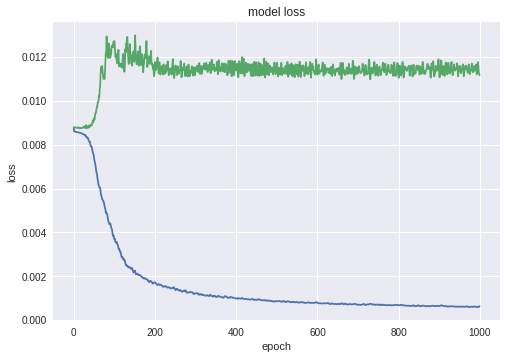

In [ ]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()